Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

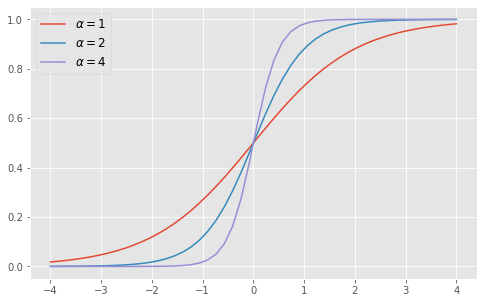

In [3]:
plt.style.use('ggplot')

sigm = lambda a, x: 1 / (1 + exp(-a*x))

x = linspace(-4, 4)
a = [1, 2, 4]
plt.figure(figsize=(8,5))
for i in a:
    plt.plot(x, sigm(i, x), label = f'$\\alpha = {i}$')

plt.legend(loc="upper left", fontsize="larger")
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
def lr_h(x, w):
    x = np.insert(x, 0, 1)
    return sigm(1, x.dot(w))

In [5]:
from sklearn.metrics import log_loss
def cross_entropy_error(X, y, w):
    loss = 0
    N = len(X)
    d_w0 = 0
    d_w = zeros(shape(X)[1])
    
    for i in range(N):
        h = lr_h(X[i], w)
        loss += -(y[i] * np.log(h) + (1-y[i]) * np.log(1-h))
        d_w0 -= h - y[i]
        d_w -= (h - y[i]) * X[i]
    return loss, d_w0, d_w

In [6]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    num_attrs = shape(X)[1]
    w_til = zeros(num_attrs + 1)
    err_curr = 0
    w_trace = []
    
    for i in range(max_iter):
        err, d_w0, d_w = cross_entropy_error(X, y, w_til)
        if abs(err_curr - err) < epsilon:
            break

        err_curr = err
        w_til[0] += eta*d_w0
        w_til[1:] = w_til[1:] * (1 - eta*alpha) + eta*d_w
        
        w_trace.append(w_til.tolist())        
    if trace:
        return w_til, w_trace
    return w_til

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [7]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Pogreška unakrsne entropije: 0.542620277674479
Težine: [ 6.44150959 -2.11012128  0.53522851]


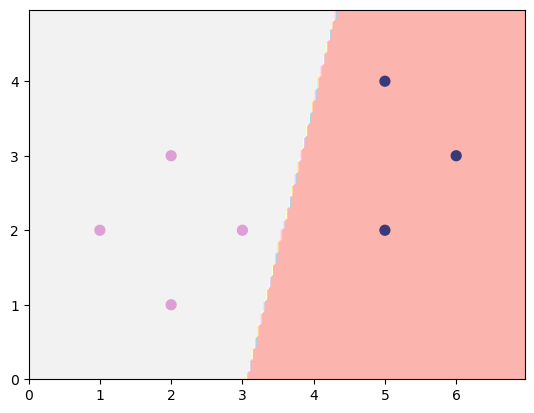

In [8]:
plt.style.use('default')

w= lr_train(seven_X, seven_y)

def lr_h(x, w):
    x = np.insert(x, 0, 1)
    return sigm(1, x.dot(w))

h = lambda x: lr_h(x, w) > 0.5
plot_2d_clf_problem(seven_X, seven_y, h)

print("Pogreška unakrsne entropije:", cross_entropy_error(seven_X, seven_y, w)[0])
print("Težine:", w)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [9]:
from sklearn.metrics import zero_one_loss
from sklearn.preprocessing import PolynomialFeatures as PolyFeat

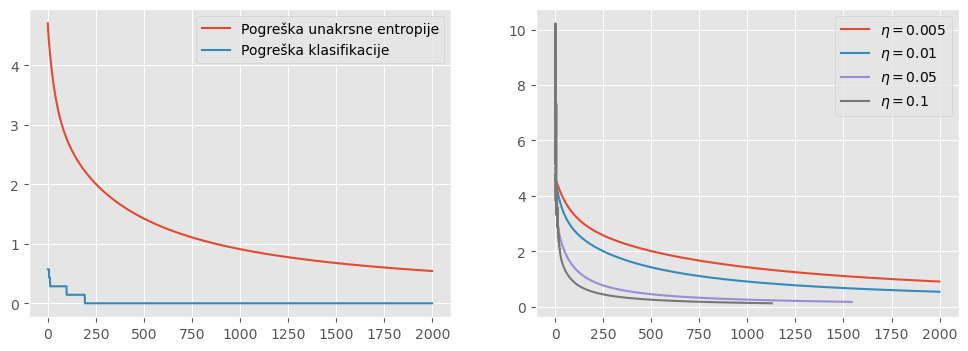

In [10]:
plt.style.use('ggplot')

eta = [0.005, 0.01, 0.05, 0.1]
w, w_trace = lr_train(seven_X, seven_y, trace=True)
X = PolyFeat(1).fit_transform(seven_X)

h = lambda x: x >= 0.5

cross_err = []
class_err = []

for wt in w_trace:
    cross_err.append(cross_entropy_error(seven_X, seven_y, wt)[0])
    seven_y_preds = h(sigm(1, X.dot(wt)))
    class_err.append(zero_one_loss(seven_y, seven_y_preds))

errs_eta = []
for e in eta:
    err = []
    w2, w2_trace = lr_train(seven_X, seven_y, eta=e, trace=True)

    for wt in w2_trace:
        err.append(cross_entropy_error(seven_X, seven_y, wt)[0])
    errs_eta.append(err)

    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot(cross_err, label="Pogreška unakrsne entropije")
plot(class_err, label="Pogreška klasifikacije")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
for i in range(len(eta)):
    plot(errs_eta[i], label=f"$\eta = {eta[i]}$")
plt.legend(loc="upper right")

plt.show()



**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

Težine: [46.26968485815002, -14.803042345814466, 4.3345416345255945]


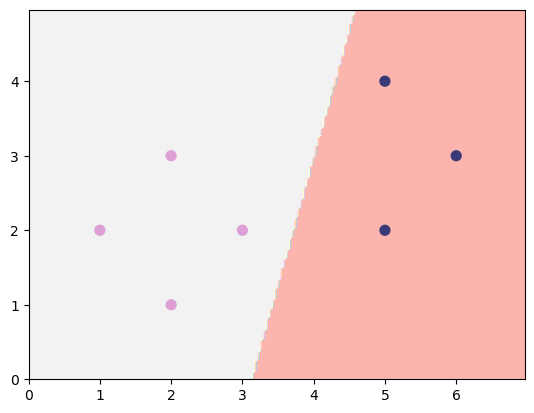

In [11]:
from sklearn.linear_model import LogisticRegression

plt.style.use('default')

log_reg = LogisticRegression(tol=0.0001, max_iter=2000, penalty="none").fit(seven_X, seven_y)
h_lr = lambda x : log_reg.predict(x)

w = log_reg.intercept_.tolist()
w.extend(log_reg.coef_[0])
print("Težine:", w)

plot_2d_clf_problem(seven_X, seven_y, h_lr)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [12]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

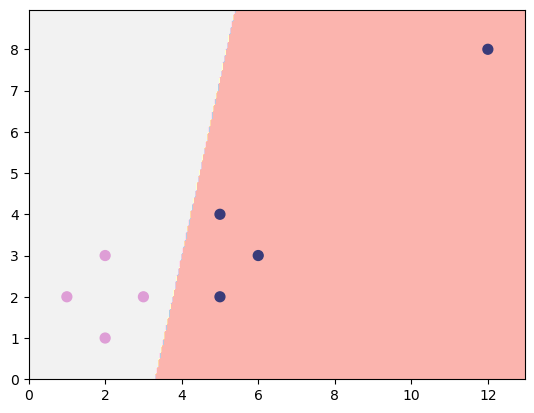

In [13]:
log_reg_out = LogisticRegression(tol=0.0001, max_iter=2000, penalty="none").fit(outlier_X, outlier_y)

h_out = lambda x : log_reg_out.predict(x)
plot_2d_clf_problem(outlier_X, outlier_y, h_out)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

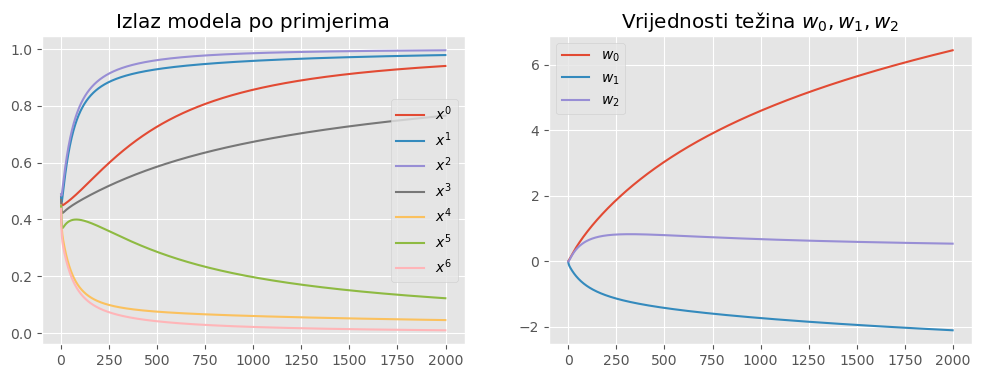

In [14]:
plt.style.use('ggplot')

w, w_tr = lr_train(seven_X, seven_y, trace=True)
w_tr = np.array(w_tr)

weights = []
for i in range(len(w_tr[0])):
    weights.append(w_tr[:, i])
    
h = []
for x in seven_X:
    h_x = []
    for wt in w_tr:
        h_x.append(lr_h(x, wt))
    h.append(h_x)
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(h)):
    plot(h[i], label=f'$x^{i}$')
plt.legend(loc="best")
plt.title("Izlaz modela po primjerima")

plt.subplot(1,2,2)
for i in range(len(weights)):
    plot(weights[i], label=f'$w_{i}$')
plt.legend(loc="best")
plt.title("Vrijednosti težina $w_0, w_1, w_2$")

plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [15]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

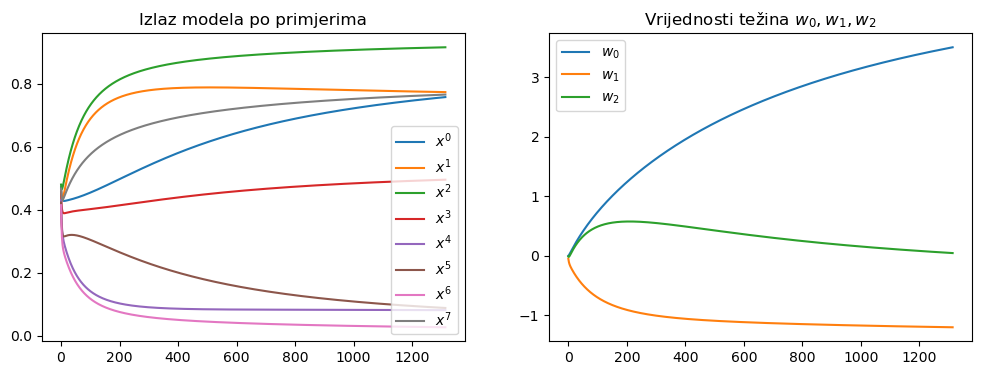

In [30]:
w, w_tr = lr_train(unsep_X, unsep_y, trace=True)
w_tr = np.array(w_tr)

weights = []
for i in range(len(w_tr[0])):
    weights.append(w_tr[:, i])
    
h = []
for x in unsep_X:
    h_x = []
    for wt in w_tr:
        h_x.append(lr_h(x, wt))
    h.append(h_x)
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(h)):
    plot(h[i], label=f'$x^{i}$')
plt.legend(loc="best")
plt.title("Izlaz modela po primjerima")

plt.subplot(1,2,2)
for i in range(len(weights)):
    plot(weights[i], label=f'$w_{i}$')
plt.legend(loc="best")
plt.title("Vrijednosti težina $w_0, w_1, w_2$")

plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [17]:
from numpy.linalg import norm

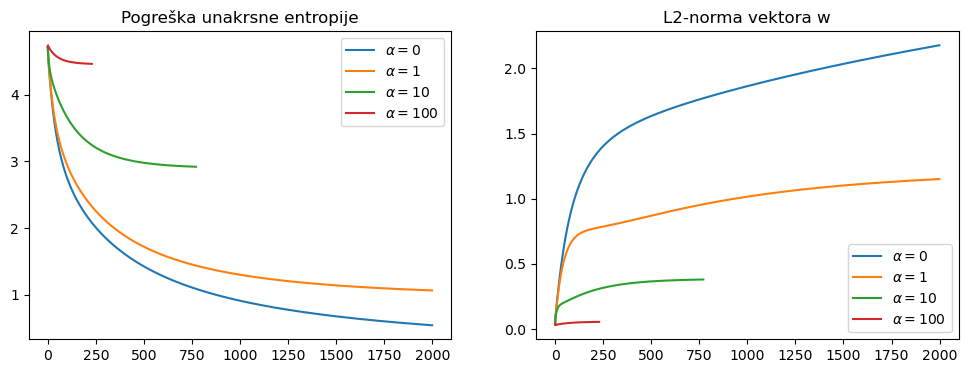

In [31]:
alpha = [0, 1, 10, 100]

err = [] 
norm_L2 = []

for a in alpha:
    w, w_tr = lr_train(seven_X, seven_y, alpha=a, trace=True)
    err_a = []
    norm_a = []
    
    for wt in w_tr:
        err_a.append(cross_entropy_error(seven_X, seven_y, wt)[0])
        norm_a.append(linalg.norm(wt[1:]))
    
    err.append(err_a)
    norm_L2.append(norm_a)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(err)):
    plot(err[i], label=f'$\\alpha = {alpha[i]}$')
plt.legend(loc="best")
plt.title("Pogreška unakrsne entropije")

plt.subplot(1,2,2)
for i in range(len(norm_L2)):
    plot(norm_L2[i], label=f'$\\alpha = {alpha[i]}$')
plt.legend(loc="best")
plt.title("L2-norma vektora w")
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [19]:
#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?

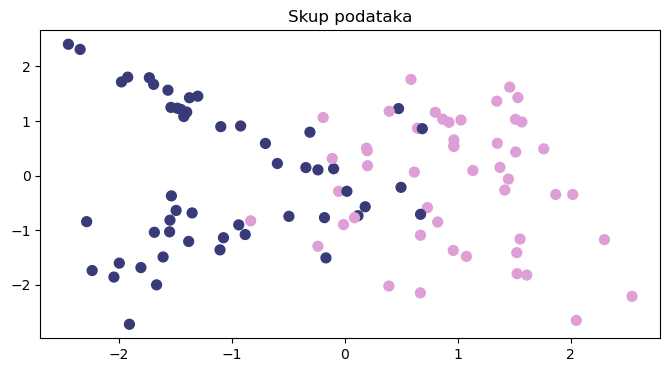

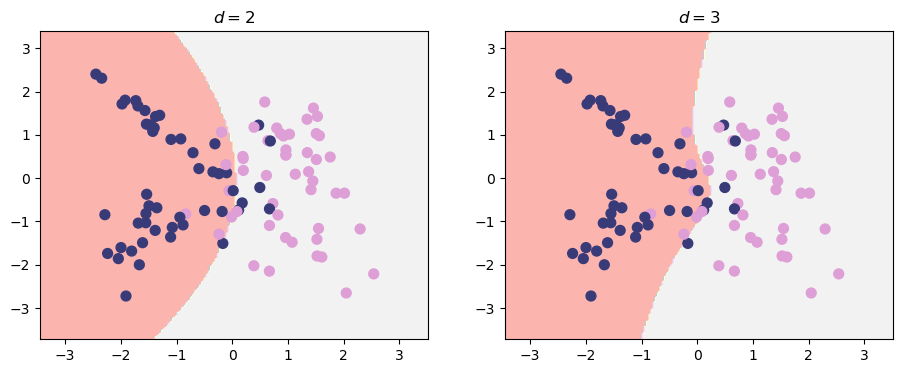

In [39]:
from sklearn.datasets import make_classification
plt.style.use('default')

X, y = make_classification(n_features=2, n_clusters_per_class=2, n_redundant=0, n_classes=2)
plt.figure(figsize(8, 4))
plot_2d_clf_problem(X, y)
plt.title("Skup podataka")

deg = [2, 3]
plt.figure(figsize(11, 4))
for i, d in enumerate(deg):
    plt.subplot(1,2,i+1)
    poly = PolyFeat(d)
    X_d = poly.fit_transform(X)
    
    model = LogisticRegression(fit_intercept=False)
    model.fit(X_d, y)
    
    h = lambda x : model.predict(poly.transform(x))
    plot_2d_clf_problem(X, y, h)
    plt.title(f"$d = {d}$")
plt.show()